#Week 06

Rishabh Thakur

21020183

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Clone this repository in which we have all functions and classes created or adapted to this work.

In [2]:
import os.path

PATH = '/content/drive/MyDrive/grape/'
if os.path.exists(PATH):
    print('grape directory already exists')
else:
    %cd /content/drive/MyDrive/
    !git clone https://github.com/UL-BDS/grape.git    
    print('Cloning grape in your Drive')

%cd /content/drive/MyDrive/grape/

grape directory already exists
/content/drive/MyDrive/grape



Import our algorithms, adapted from deap.algorithms.

Import DEAP.

Import functions used by our grammars.



In [3]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [4]:
!pip install deap==1.3 

from ponyge2_adapted_files import Grammar, ge
import algorithms
from functions import not_, and_, or_, nand_, nor_

from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from deap import creator, base, tools

     |████████████████████████████████| 152 kB 5.0 MB/s 


Set our Grammatical Evolution parameters.

In [18]:
POPULATION_SIZE = 1000
MAX_GENERATIONS = 50
P_CROSSOVER = 0.8
P_MUTATION = 0.01
ELITE_SIZE = round(0.01*POPULATION_SIZE)

HALL_OF_FAME_SIZE = 1
MAX_INIT_TREE_DEPTH = 10
MIN_INIT_TREE_DEPTH = 1
MAX_TREE_DEPTH = 17
MAX_WRAPS = 0
CODON_SIZE = 255

Set a problem to solve. We can choose 'parity3', 'parity4' or 'parity5'.

The parameters in the previous cell are recommended to solve the problem with 3 bits. 

In [19]:
problem = 'parity4'

Read datasets and grammars according to the problem picked in the previous cell.

Notice we read the data in from a file rather than simply generate it. While not strictly necessary, it is a nice piece of functionality that we'll use in later notebooks.

In [20]:
if problem == 'parity3':
    X_train = np.zeros([3,8], dtype=bool)
    Y_train = np.zeros([8,], dtype=bool)

    data = pd.read_table(r"datasets/parity3.csv")
    for i in range(3):
        for j in range(8):
            X_train[i,j] = data['d'+ str(i)].iloc[j]
    for i in range(8):
        Y_train[i] = data['output'].iloc[i]
        
    GRAMMAR_FILE = 'parity3.bnf'

elif problem == 'parity4':
    X_train = np.zeros([4,16], dtype=bool)
    Y_train = np.zeros([16,], dtype=bool)

    data = pd.read_table(r"datasets/parity4.csv")
    for i in range(4):
        for j in range(16):
            X_train[i,j] = data['d'+ str(i)].iloc[j]
    for i in range(16):
        Y_train[i] = data['output'].iloc[i]
        
    GRAMMAR_FILE = 'parity4.bnf'

elif problem == 'parity5':
    X_train = np.zeros([5,32], dtype=bool)
    Y_train = np.zeros([32,], dtype=bool)

    data = pd.read_table(r"datasets/parity5.csv")
    for i in range(5):
        for j in range(32):
            X_train[i,j] = data['d'+ str(i)].iloc[j]
    for i in range(32):
        Y_train[i] = data['output'].iloc[i]
        
    GRAMMAR_FILE = 'parity5.bnf'

Print data.

In [21]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(data)

,d0,d1,d2,d3,output
0,0,0,0,0,1
1,0,0,0,1,0
2,0,0,1,0,0
3,0,0,1,1,1
4,0,1,0,0,0
5,0,1,0,1,1
6,0,1,1,0,1
7,0,1,1,1,0
8,1,0,0,0,0
9,1,0,0,1,1


Print grammar.

In [22]:
f = open("grammars/" + GRAMMAR_FILE, "r")
print(f.read())
f.close() 

<e>  ::=  and_(<e>,<e>)|
          or_(<e>,<e>)|
          nand_(<e>,<e>)|
          nor_(<e>,<e>)|
          x[0]|x[1]|x[2]|x[3]



Set up the grammar addressed by GRAMMAR_FILE in the class Grammar.

In [23]:
BNF_GRAMMAR = Grammar(path.join("grammars", GRAMMAR_FILE))

Define as fitness function the number of outputs wrongly predicted.

In [24]:
def fitness_eval(individual, points):
    x = points[0]
    Y = points[1]
    
    if individual.invalid == True:
        return np.NaN,

    # Evaluate the expression
    try:
        pred = eval(individual.phenotype)
    except (FloatingPointError, ZeroDivisionError, OverflowError,
            MemoryError):
        # FP err can happen through eg overflow (lots of pow/exp calls)
        # ZeroDiv can happen when using unprotected operators
        return np.NaN,
    assert np.isrealobj(pred)

    # The expected outputs are in Y
    n_samples = len(Y)
    compare = np.equal(Y,pred) # Compare the outputs with the expected values
    n_correct_outputs = np.sum(compare)
    
    fitness = n_samples - n_correct_outputs
    
    return fitness,

Create the deap toolbox.

Use negative weights in the `base.Fitness` since we are trying to minimise the fitness.

`ge.Individual` is a class with the following attributes: `phenotype`, `genome`, `tree`, `nodes`, `invalid` (True or False), `depth` and `used_codons`.

Usually, when using deap, we initialise each individual independently, and then we repeat that until we fill out the whole population. However, since we are using Position Independent Grow Initialisation, we need to initialise all individuals simultaneously (because we want them to be unique).

`ge.selTournament` prevents selecting invalid individuals.

`ge.crossover_onepoint` selects crossover points within the used portion of the genome. 

Similarly, `ge.mutation_int_flip_per_codon` performs only over the effective length.



In [25]:
toolbox = base.Toolbox()

# define a single objective, minimising fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

creator.create('Individual', ge.Individual, fitness=creator.FitnessMin)

toolbox.register("populationCreator", ge.initialisation_PI_Grow, creator.Individual) 

toolbox.register("evaluate", fitness_eval)

# Tournament selection:
toolbox.register("select", ge.selTournament, tournsize=7)

# Single-point crossover:
toolbox.register("mate", ge.crossover_onepoint)

# Flip-int mutation:
toolbox.register("mutate", ge.mutation_int_flip_per_codon)


Set the main function and run it.

Set the statistics object regarding the fitness score, but there are other statistics defined internally.

Perform Grammatical Evolution using `algorithms.ge_eaSimple`, a simple evolutionary algorithm. The differences to the `algorithms.eaSimple` used by deap are:

*   We use elitism;
*   After crossover and mutation, we check the offspring to assure that the max tree depth is not violated;
*   We measure the generation and the selection times;
*   We count the number of invalid individuals.

In [26]:
# create initial population (generation 0):
population = toolbox.populationCreator(size=POPULATION_SIZE, 
                                        bnf_grammar=BNF_GRAMMAR, 
                                        min_init_tree_depth=MIN_INIT_TREE_DEPTH,
                                        max_init_tree_depth=MAX_INIT_TREE_DEPTH,
                                        max_tree_depth=MAX_TREE_DEPTH, 
                                        max_wraps=MAX_WRAPS,
                                        codon_size=CODON_SIZE
                                        )

# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

# prepare the statistics object:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.nanmean)
stats.register("std", np.nanstd)
stats.register("min", np.nanmin)
stats.register("max", np.nanmax)

# perform the Grammatical Evolution flow:
population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                          ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                          bnf_grammar=BNF_GRAMMAR, codon_size=CODON_SIZE, 
                                          max_tree_depth=MAX_TREE_DEPTH, max_wraps=MAX_WRAPS,
                                          points_train=[X_train, Y_train], 
                                          stats=stats, halloffame=hof, verbose=True)

gen	invalid	avg 	std    	min	max	best_ind_length	avg_length	max_length	selection_time	generation_time
0  	0      	7.98	0.48949	6  	10 	31             	53.14     	343       	0             	0.144336       
1  	450    	7.95818	0.422198	6  	9  	304            	62.986    	342       	0.0139875     	3.14378        
2  	191    	7.8529 	0.481417	6  	9  	304            	54.056    	304       	0.015131      	0.629945       
3  	153    	7.77568	0.557633	6  	10 	304            	54.713    	304       	0.0138395     	1.21681        
4  	128    	7.69495	0.600896	6  	9  	304            	60.627    	313       	0.0145152     	0.527996       
5  	103    	7.61315	0.641178	6  	10 	304            	64.06     	304       	0.0161572     	0.638014       
6  	83     	7.54308	0.695482	6  	10 	304            	62.654    	304       	0.0133271     	0.504169       
7  	76     	7.49892	0.730444	6  	10 	304            	66.486    	304       	0.0137541     	0.689488       
8  	59     	7.39532	0.784371	5  	9  	63             	6

Extract statistics and build a nice looking table.

In [27]:
max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
min_fitness_values, std_fitness_values = logbook.select("min", "std")
best_ind_length = logbook.select("best_ind_length")
avg_length = logbook.select("avg_length")
max_length = logbook.select("max_length")
selection_time = logbook.select("selection_time")
generation_time = logbook.select("generation_time")
gen, invalid = logbook.select("gen", "invalid")

header = ['gen', 'invalid', 'avg', 'std', 'min', 'max', 'best_ind_length', 'avg_length', 'max_length', 'selection_time', 'generation_time']

results = pd.DataFrame(list(zip(gen, invalid, mean_fitness_values, std_fitness_values, min_fitness_values, max_fitness_values, best_ind_length, avg_length, max_length, selection_time, generation_time)),
               columns = header)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(results)

,gen,invalid,avg,std,min,max,best_ind_length,avg_length,max_length,selection_time,generation_time
0,0,0,7.980000,0.489490,6.0,10.0,31,53.140,343,0.000000,0.144336
1,1,450,7.958182,0.422198,6.0,9.0,304,62.986,342,0.013988,3.143780
2,2,191,7.852905,0.481417,6.0,9.0,304,54.056,304,0.015131,0.629945
3,3,153,7.775679,0.557633,6.0,10.0,304,54.713,304,0.013839,1.216809
4,4,128,7.694954,0.600896,6.0,9.0,304,60.627,313,0.014515,0.527996
5,5,103,7.613155,0.641178,6.0,10.0,304,64.060,304,0.016157,0.638014
6,6,83,7.543075,0.695482,6.0,10.0,304,62.654,304,0.013327,0.504169
7,7,76,7.498918,0.730444,6.0,10.0,304,66.486,304,0.013754,0.689488
8,8,59,7.395324,0.784371,5.0,9.0,63,66.509,304,0.013600,0.503440
9,9,62,7.292111,0.868767,5.0,10.0,63,72.255,317,0.017175,0.565535


Show the best individual as an expression.

In [28]:
print("Best individual: ")
print(hof.items[0].phenotype)
print()
print("Training Fitness: ", hof.items[0].fitness.values[0])
print()
print("Depth: ", hof.items[0].depth)
print()
print("Length of the genome: ", len(hof.items[0].genome))
print()
print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')
print()

Best individual: 
or_(and_(nor_(x[1],and_(and_(x[0],x[3]),x[3])),x[2]),nor_(and_(and_(or_(nor_(x[2],nor_(and_(and_(or_(nor_(nand_(x[2],x[3]),x[2]),x[1]),x[3]),x[0]),or_(x[2],nor_(x[0],x[1])))),x[2]),x[3]),or_(or_(and_(x[2],nor_(x[3],x[0])),or_(nor_(x[3],x[2]),nand_(x[2],x[1]))),nand_(x[0],x[3]))),and_(and_(x[1],and_(and_(x[0],x[2]),or_(x[2],or_(and_(and_(nor_(nand_(x[1],x[2]),x[3]),or_(or_(and_(or_(x[2],nor_(x[0],x[1])),x[2]),x[3]),nor_(nand_(and_(nor_(nand_(x[0],x[1]),x[1]),x[0]),or_(x[2],x[1])),nand_(x[0],x[3])))),x[1]),or_(x[2],x[1]))))),nand_(x[0],x[3]))))

Training Fitness:  3.0

Depth:  17

Length of the genome:  123

Used portion of the genome: 0.82



Plot graphs regarding the best fitness and the average fitness.

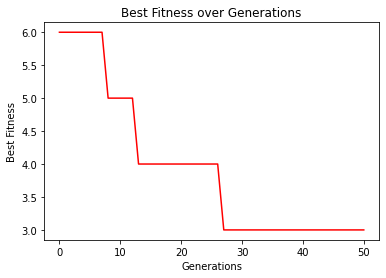

In [29]:
plt.plot(min_fitness_values, color='red')
plt.xlabel('Generations')
plt.ylabel('Best Fitness')
#plt.title('Max and Average Fitness over Generations')
plt.title('Best Fitness over Generations')
plt.show()


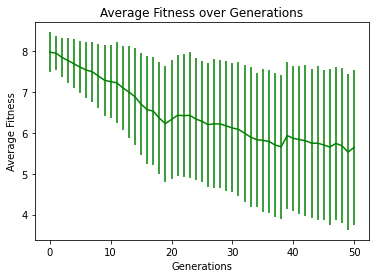

In [30]:
gen = np.arange(0, 50+1)

plt.xlabel('Generations')
plt.ylabel('Average Fitness')
plt.title('Average Fitness over Generations')
plt.errorbar(gen, mean_fitness_values, yerr=std_fitness_values,label="Best", color="Green")
plt.show()

Plot graphs regarding the length of the genome: the maximum value, the average of the population and that one of the best individual.


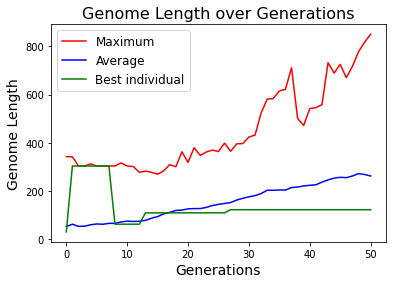

In [31]:
plt.plot(gen, max_length, color='red', label="Maximum")
plt.plot(gen, avg_length, color='blue', label="Average")
plt.plot(gen, best_ind_length, color='green', label="Best individual")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Genome Length over Generations', fontsize=16)
plt.show()